불확실성 고려 

- 오차 행렬과, 분류 리포트가 예측결과를 분석 할 수 있도록 도와주지만 예측값은 모델에 담긴 많은 정보가 이미 손실된 상태이다. 
- 분류기의 예측 확신을 가늠하기 위한 decision_function, predict_proba 메서드를 제공하낟. 
- 예측을 만드는 것은 decision_function, predict_proba출력의 임계값을 검증하는 것.
- 이진 탐색에서는 0.5를 각 임계값으로 사용한다. 


In [3]:
#SVM학습시킨 모델을 decision_function 0일 떄의 임계점확인
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from sklearn.svm import SVC

X, y = make_blobs(n_samples = (400, 50), cluster_std = [7.0, 2], random_state = 22)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
svc = SVC(gamma = .05).fit(X_train, y_train)

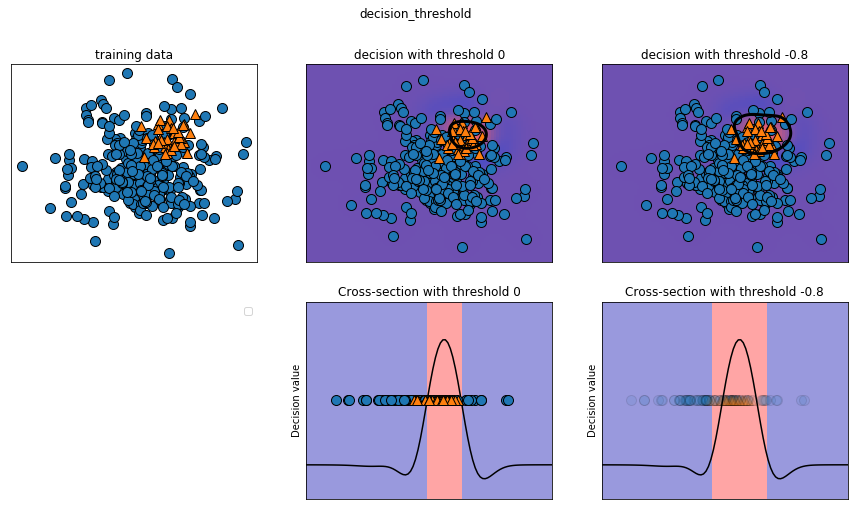

In [5]:
import mglearn
mglearn.plots.plot_decision_threshold()

In [6]:
#classification_report를 통한 두 클래스의 정밀도와 재현율 평가 
from sklearn.metrics import classification_report

print(classification_report(y_test, svc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93       104
           1       0.35      0.67      0.46         9

    accuracy                           0.88       113
   macro avg       0.66      0.78      0.70       113
weighted avg       0.92      0.88      0.89       113



클래스 0의 샘플이 매우 많으므로 분류기는 소수인 클래스 1보다 0에 초점을 맞추고 있다. 

이 모델이 암진단 예와 같이 클래스 1의 재현율을 높이는 것이 중요하다고 가정해 본다. 

In [7]:
y_pred_lower_threshold = svc.decision_function(X_test) > -.8

In [8]:
print(classification_report(y_test, y_pred_lower_threshold))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90       104
           1       0.32      1.00      0.49         9

    accuracy                           0.83       113
   macro avg       0.66      0.91      0.69       113
weighted avg       0.95      0.83      0.87       113



- 클래스 1의 재현율(recall)이 높아지고 정밀도(precision)은 낮아졌다. 

- 데이터가 심하게 불균형일 경우 결정 함수의 임계값을 바꾸면 더 나은 결과를 얻을 수 있다. 

- decision_function은 임의의 범위를 가지고 있으므로 임계점을 고르는 일반적인 방법을 제시하기는 어렵다. 

- 임계값을 선택할 때, 테스트 셋을 사용하지 않도록 주의해야한다. 

- (과도하게 낙관적인 결과를 만들어, 테스트셋 대신 검증 세트 혹은 교차검증 이용이 효과적이다. )

- predict_proba를 제공하는 메서드는 출력이 0~1 사이 고정이므로 이를 제공하는 모델은 임계깞 선택이 더 쉽다. 

- 임계값이 0.5인 모델은 양성 클래스라는 확신이 50%이상일 때 양성으로 분류한다. 

- 임의의 임계값보다는 확률을 사용하는 쪽이 더 직관적이지만, 모든 모델이 쓸모 있는 불확실성을 제공하는 것은 아니다.

- 이는 보정과 연관되어 있어, 보정된 모델은 불확실성을 정확하게 측정하는 모델이다. 
  (보정에 대한 자세한 개념은 https://bit/ly/2LfMILV 참고 )

정밀도 - 재현율 곡선과 ROC곡선

- 모델의 분류작업을 결정하는 임계값을 바꾸는 것은 해당 분류기의 정밀도와 재현율의 상충관계를 조정하는 일이다. 
- FN를 10%보다 작게하여 90%이상의 재현율을 원할 수도 있는데 이는 모델의 비즈니스 목표에 따라 결정된다. 
- 이때 어려운 부분은 임계깞을 유지하며 적절항 정밀도를 만들어 내는 모델을 만드는 일이다. 
- 분류기의 필요조건을 지정하는 것을 운영포인트를 지정한다고 말한다. (비즈니스 목표설정, 성능 보장시 도움)
- 새로운 모델 개발시 운영포인트가 명확하지 않은 경우가 많아, 문제를 더 잘 이해하기 위해 모든 임계값을 조사하거나,

  정밀도나 재현율의 모든 장단점을 살펴보는 것이 좋다. (정밀도 - 재현율 곡선 이용)
- 정밀도-재현율 곡선은 타겟 레이블과 decision_function, predict_proba메서드로 계산한 예측 불확실성을 이용한다. 

In [10]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve( y_test, svc.decision_function(X_test))

precision_recall_curve 함수는 가능한 모든 임계값에 대해 정밀도와 재현율의 값을 정렬된 리스트로 반환하여 곡선 그래프를 그릴 수 있다. 

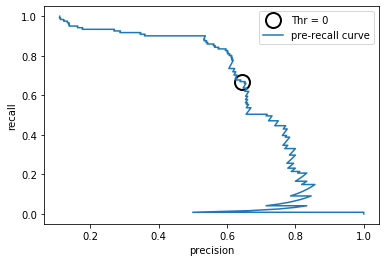

In [13]:
#부드러운 곡선위한 데이터 포인트 수 늘림
import numpy as np
import matplotlib.pyplot as plt

X, y = make_blobs(n_samples = (4000, 500), cluster_std=[7.0,2], random_state = 22)
X_train, X_test, y_train, y_test = train_test_split(X, y , random_state = 0)

svc = SVC(gamma = .05).fit(X_train, y_train)

precision, recall, thresholds = precision_recall_curve(y_test, svc.decision_function(X_test))

#0에 가까운 임계값 탐색
close_zero = np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=15, label = 'Thr = 0', fillstyle='none',c='k',mew =2)

plt.plot(precision, recall, label = 'pre-recall curve')
plt.xlabel('precision')
plt.ylabel('recall')
plt.legend(loc='best')

곡선의 각 포인트는 decision_function의 가능한 모든 임계값에 대응한다. 

임계값이 0인 지점은 predict 메서드를 호출할 때 사용되는 임계값이다. 

곡선이 오른쪽 위로 갈수록 더 좋은 분류기 이다. 

이 분류기는 임계값이 매우 낮아 전부 양성 클래스가 되는 왼쪽에서 시작한다. 

재현율과 정밀도를 둘다 높게 가져갈 수는 없는 모델이다.

분류기가 다르면 곡선의 다른 부분에서 장점이 생긴다. (운영포인트가 달라진다. )

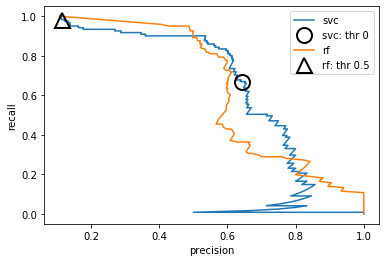

In [23]:
#랜덤포레스트와의 비교 

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 100, random_state = 0, max_features = 2)
rf.fit(X_train, y_train)

#rf는 predict_proba 제공
precision_rf, recall_rf, thresholds_rf = precision_recall_curve( y_test, rf.predict_proba(X_test)[:,1])

plt.plot(precision, recall, label='svc')

plt.plot(precision[close_zero], recall[close_zero], 'o', markersize = 15, 
        label='svc: thr 0', fillstyle = 'none', c='k', mew = 2)

plt.plot(precision_rf, recall_rf, label='rf')

#predict_proba의 기본 임계값은 0.5
close_default_rf = np.argmin(np.abs(thresholds_rf-0.5))

plt.plot(precision[close_default_rf], recall[close_default_rf], '^', c='k', markersize= 15, 
        label = 'rf: thr 0.5', fillstyle = 'none', mew =2)

plt.xlabel('precision')
plt.ylabel('recall')
plt.legend(loc='best')

그래프 비교시 극단적인 부분에서는 랜덤포레스트가 더 낫다는 것을 알 수 있다. 

만약 f1스코어만으로 전체 성능을 비교한다면 이런 세세한 부분을 놓칠 수 있다. 

f1점수는 정밀도-재현율 곡선의 한 지점인 기본 임계값에 대한 점수이다. 

In [25]:
from sklearn.metrics import f1_score
print('랜덤 포레스트의 f1 score ',f1_score(y_test, rf.predict(X_test)))
print('SVC의 f1 score ', f1_score(y_test, svc.predict(X_test)))

랜덤 포레스트의 f1 score  0.6097560975609757
SVC의 f1 score  0.6558704453441295


정밀도 - 재현율 곡선을 비교하면 많은 통찰을 얻을 수 있지만 수작업이다. 

모델을 자동으로 비교하려면 특정 임계값이나 운영포인트에 국한하지 않고 전체 곡선에 담긴 정보를 요약해야 한다. 

이러한 요약 방법의 하나로 정밀도 재현율 곡선의 아랫부분 면적을 계산할 수 있으며, 이를 평균 정밀도라고 한다. 

average_precision_score 함수가 평균 정밀도를 계산해 준다. 

In [26]:
from sklearn.metrics import average_precision_score

ap_rf =average_precision_score(y_test, rf.predict_proba(X_test)[:,1])
ap_svc = average_precision_score(y_test, svc.decision_function(X_test))

print('랜덤 포레스트의 평균 정밀도 :', ap_rf)
print('svc의 평균 정밀도 :', ap_svc)

랜덤 포레스트의 평균 정밀도 : 0.659559370099291
svc의 평균 정밀도 : 0.6663140319391998


모든 임계값에 대하여 랜덤포레스트가 살짝 낮지만, f1 스코어와의 결과는 다르다. 

평균 정밀도는 0 ~ 1사이를 지나는 곡선의 아래 면적이므로 항상 0 ~ 1 사이의 값을 반환한다. 

무작위로 예측하는 분류기의 decision_function의 평균 정밀도는 데이터셋에 있는 양성 클래스의 비율이 된다. 

ROC와 AUC곡선

- ROC곡선은 여러 임계값에서 분류기의 특성 분석하는데 널리 이용되는 도구 
  
  (분류기의 모든 임계값을 고려하지만 정밀도와 재현율 대신 TPR, FPR을 나타낸다. )

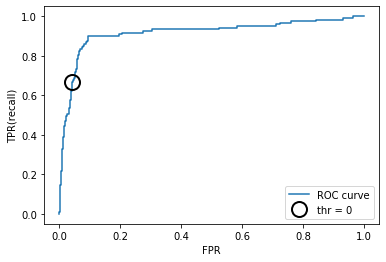

In [28]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, svc.decision_function(X_test))

plt.plot(fpr, tpr, label='ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR(recall)')

#0근처의 임계값 탐색
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize =15, 
        label = 'thr = 0', fillstyle = 'none', c='k', mew =2)
plt.legend(loc=4)

ROC 곡선은 왼쪽위에 가까울수록 이상적이다. (FPR이 낮게 유지되며 TPR이 높기 때문 )

기본 임계값 0의 지점과 비교했을 때, FPR을 조금 늘리면 재현율을 크게 높일 수 있다. 

ROC 커브도 마찬가지로 임계값을 고르기 위해 테스트 세트를 사용해서는 안되고 별도의 검증세트를 활용해야 한다. 

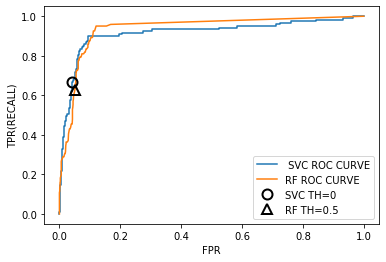

In [30]:
#랜덤포레스트와의 비교

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr, label =' SVC ROC CURVE')
plt.plot(fpr_rf, tpr_rf, label = 'RF ROC CURVE')

plt.xlabel('FPR')
plt.ylabel('TPR(RECALL)')
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10, 
        label = 'SVC TH=0', fillstyle = 'none', c='k', mew = 2)

close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(fpr_rf[close_default_rf], tpr_rf[close_default_rf], '^', markersize=10,
        label = 'RF TH=0.5', fillstyle='none', c='k', mew = 2)

plt.legend(loc=4)

정밀도 - 재현율 곡선에서처럼 곡선 아래의 면적값 하나로 ROC 곡선을 요약할 떄가 많다.

이 면적을 보통 AUC라고 한다. 

In [33]:
from sklearn.metrics import roc_auc_score

rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])
svc_auc = roc_auc_score(y_test, svc.decision_function(X_test))

print('RF AUC :', rf_auc)
print('SVC AUC :', svc_auc)

RF AUC : 0.9366953672911659
SVC AUC : 0.9162935036712654


- auc 점수로 비교해보니 RF의 성능이 조금 더 낫다. 

- auc가 0과 1사이의 곡선 아래 면적이므로 항상 0과 1사이의 값을 가진다. 

- 데이터셋이 아무리 불균형하더라도 무작위로 예측한 auc값은 0.5가된다. 

- 그래서 불균형 데이터셋에서는 정확도보다 auc가 훨씬 좋은 지표이다. 

- auc는 양성 샘플의 순위를 평가하는 것으로 볼 수 있다. 

- 한 양성 클래스 포인트의 점수가 무작위로 선택한 음성 클래스 포인트의 점수보다 높을 확률과 같아 auc가 1일때는

  모든 양성 포인트의 점수가 모든 음성 포인트의 점수 보다 높다. 

gamma = 1.00  정확도 = 0.90  AUC = 0.50
gamma = 0.10  정확도 = 0.90  AUC = 0.96
gamma = 0.01  정확도 = 0.90  AUC = 1.00


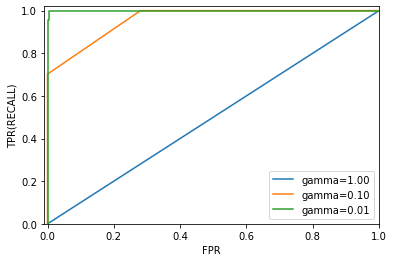

In [35]:
#digits 데이터셋 이용
from sklearn.datasets import load_digits

digits = load_digits()
y = digits.target ==9

X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state = 0)

plt.figure()

for gamma in [1, 0.1, 0.01]:
    svc = SVC(gamma = gamma).fit(X_train, y_train)
    accuracy = svc.score(X_test, y_test)
    auc = roc_auc_score(y_test, svc.decision_function(X_test))
    fpr, tpr, _ = roc_curve(y_test, svc.decision_function(X_test))
    print('gamma = {:.2f}  정확도 = {:.2f}  AUC = {:.2f}'.format(gamma, accuracy, auc))
    
    plt.plot(fpr, tpr, label = 'gamma={:.2f}'.format(gamma))
    
plt.xlabel('FPR')
plt.ylabel('TPR(RECALL)')
plt.xlim(-0.01, 1)
plt.ylim(0, 1.02)
plt.legend(loc='best')

- 세 가지 gamma 값에 대한 정확도는 90%로 같지만, AUC와 ROC곡선을 보면 차이가 확인된다. 
- gamma=1의 AUC는 무작위 선택 수준, gamma = 0.1에서는 auc의 값이 0.96으로 크게 향상 되고 1인 경우에서는 완벽한 AUC값 획득
- 즉 결정함수에 의해 모든 양성 포인트는 어떤 음성포인트보다 더 높은 점수를 가진다. (적절 임계값에서는 데이터를 완벽하게 분류 가능)


다중 분류의 평가지표 

- 다중분류를 위한 지표는 이진 분류 평가 지표에서 유도되었으며, 다만 모든 클래스에 대해 평균을 낸 것이다. 
- 다중 분류의 평가에는 정확도 외에 앞의 이진분류에서 이용한 오차 행렬과 분류 리포트 등을 일반적으로 사용한다. 

In [36]:
#digits 데이터셋에 10개 손글씨 숫자 분류에 다중분류 평가 적용
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, random_state=0)

lr = LogisticRegression(solver = 'liblinear', multi_class='ovr').fit(X_train, y_train)
pred = lr.predict(X_test)
print('정확도 :', accuracy_score(y_test, pred))
print('오차 행렬 : \n', confusion_matrix(y_test, pred))

정확도 : 0.9533333333333334
오차 행렬 : 
 [[37  0  0  0  0  0  0  0  0  0]
 [ 0 39  0  0  0  0  2  0  2  0]
 [ 0  0 41  3  0  0  0  0  0  0]
 [ 0  0  1 43  0  0  0  0  0  1]
 [ 0  0  0  0 38  0  0  0  0  0]
 [ 0  1  0  0  0 47  0  0  0  0]
 [ 0  0  0  0  0  0 52  0  0  0]
 [ 0  1  0  1  1  0  0 45  0  0]
 [ 0  3  1  0  0  0  0  0 43  1]
 [ 0  0  0  1  0  1  0  0  1 44]]


이 모델의 정확도는 95.3%로 꽤 좋은 성능이고 오차 행렬의 행은 각 정답레이블, 열은 예측 레이블에 해당한다. 

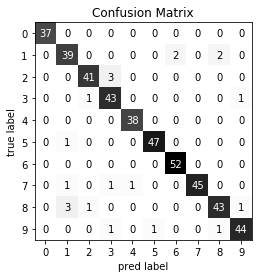

In [37]:
#오차 행렬 그래프로 표현
scores_image = mglearn.tools.heatmap(confusion_matrix(y_test, pred), xlabel = 'pred label',
                                     ylabel = 'true label', xticklabels = digits.target_names,
                                     yticklabels = digits.target_names, cmap = plt.cm.gray_r, fmt='%d')
plt.title('Confusion Matrix')
plt.gca().invert_yaxis()

In [38]:
#classification_report 이용
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       0.89      0.91      0.90        43
           2       0.95      0.93      0.94        44
           3       0.90      0.96      0.92        45
           4       0.97      1.00      0.99        38
           5       0.98      0.98      0.98        48
           6       0.96      1.00      0.98        52
           7       1.00      0.94      0.97        48
           8       0.93      0.90      0.91        48
           9       0.96      0.94      0.95        47

    accuracy                           0.95       450
   macro avg       0.95      0.95      0.95       450
weighted avg       0.95      0.95      0.95       450



- 이 모델은 대체적으로 손글씨 숫자를 잘 분류하지만 1, 3, 8을 분류하는데 성능이 떨어진다. 
- 다중 분류에서 불균형 데이터셋을 위해 가장 널리 이용하는 평가 지표는 f1스코어의 다중분류 버전이다. 
    - 다중 분류 버전 f1스코어는 한 클래스를 양성 클래스로 두고 나머지 클래스들을 음성 클래스로 간주하여 클래스마다 f1스코어를 계산한다.
    - 그런 다음 클래스별 f1스코어를 다음 전략 중 하나를 이용하여 평균을 낸다. 
        - 'macro' - 평균은 클래스별 f1스코어에 가중치를 주지 않고 크기 상관없이 모든 클래스를 같은 비중으로 다룬다. 
        - 'weighted' - 평균은 클래스별 샘플 수로 가중치를 두어 f1스코어 평균을 계산한다.
        - 'micro' -  평균은 모든 클래스의 FP, FN, TP의 총수를 헤아린 다음 정밀도, 재현율, f1스코어를 이 수치로 계산한다.
        
    - 각 샘플을 똑같이 간주한다면 'micro', 각 클래스를 동일한 비중으로 고려한다면 'macro' 평균 f1스코어 이용
    
 

In [39]:
print('micro 평균 f1 스코어 :', f1_score(y_test, pred, average ='micro'))
print('macro 평균 f1 스코어 :', f1_score(y_test, pred, average='macro'))

micro 평균 f1 스코어 : 0.9533333333333334
macro 평균 f1 스코어 : 0.9539995483362096


회귀 평가의 지표

- 회귀 평가는 분류와 비슷하게 할 수 있다. 
- 과대적합, 과소적합을 분석한다. 대부분의 애플리케이션에서는 회귀 추정기의 score 메서드에서 이용하는 R2만으로 충분하다.
- 가끔 평균제곱에러(MSE), 평균 절댓값 에러(MAE)를 이용하여 모델을 튜닝할 때 이런 지표를 기반으로 비즈니스 결정을 할 수 있다.

모델 선택에서 평가지표 사용하기 

- GridSearchCV, cross_val_score 이용하여 모델 선택시, AUC같은 평가지표를 사용하고 싶은 경우가 많다. 
- sklearn에서는 scoring 매개변수를 통해 쉽게 구현할 수 있다. 사용하려는 평가지표를 문자열로 넘겨주면 된다. 

In [42]:
from sklearn.model_selection import cross_val_score

print('기본 평가 지표:', cross_val_score(SVC(), digits.data, digits.target ==9, cv=5))

explicit_accuracy = cross_val_score(SVC(), digits.data, digits.target == 9, scoring='accuracy', cv=5)

print('정확도 지표 :', explicit_accuracy)

roc_auc = cross_val_score(SVC(), digits.data, digits.target==9, scoring='roc_auc', cv=5)

print('평균 정밀도 지표 :', roc_auc)


c:\users\cndak\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\cndak\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\cndak\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureW

기본 평가 지표: [0.9        0.9        0.89972145 0.89972145 0.89972145]


c:\users\cndak\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\cndak\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\cndak\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureW

정확도 지표 : [0.9        0.9        0.89972145 0.89972145 0.89972145]


c:\users\cndak\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\cndak\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\cndak\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureW

평균 정밀도 지표 : [0.99674211 0.99725652 0.99552804 0.99836601 0.99165807]


In [46]:
#cross_validate 함수를 사용하여 한번에 여러 지표 계싼
from sklearn.model_selection import cross_validate 
import pandas as pd

res = cross_validate( SVC(), digits.data, digits.target ==9, scoring=['accuracy', 'roc_auc','recall_macro'], return_train_score=True, cv=5)

display(pd.DataFrame(res))


c:\users\cndak\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\cndak\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\cndak\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureW

,fit_time,score_time,test_accuracy,train_accuracy,test_roc_auc,train_roc_auc,test_recall_macro,train_recall_macro
0,0.173555,0.102695,0.900000,1.0,0.996742,1.0,0.5,1.0
1,0.165021,0.103027,0.900000,1.0,0.997257,1.0,0.5,1.0
2,0.165199,0.099933,0.899721,1.0,0.995528,1.0,0.5,1.0
3,0.165085,0.102489,0.899721,1.0,0.998366,1.0,0.5,1.0
4,0.160203,0.099846,0.899721,1.0,0.991658,1.0,0.5,1.0


위와 비슷하게 GridSearchCV에서 최적 매개변수 선택 위한 평가 지표를 바꿀 수 있다. 

In [48]:
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target ==9, random_state=0)

#일부러 이상한 그리드 생성
param_grid = {'gamma':[0.0001, 0.01, 0.1, 1, 10]}

#기본 정확도 지표 이용
grid = GridSearchCV(SVC(), param_grid=param_grid, cv = 3)
grid.fit(X_train, y_train)

print('정확도 지표 이용 그리드 서치')
print('최적 파라미터 :', grid.best_params_)
print('최상 교차 검증 점수(정확도) :', grid.best_score_)
print('테스트 셋 평균 정밀도 : ', average_precision_score(y_test, grid.decision_function(X_test)))
print('테스트 셋 정확도 :', grid.score(X_test, y_test))

정확도 지표 이용 그리드 서치
최적 파라미터 : {'gamma': 0.0001}
최상 교차 검증 점수(정확도) : 0.9703043801039347
테스트 셋 평균 정밀도 :  0.9656749529729884
테스트 셋 정확도 : 0.9733333333333334


In [49]:
grid = GridSearchCV(SVC(), param_grid = param_grid, scoring='average_precision', cv=3)
grid.fit(X_train, y_train )
print('평균 정밀도 이용 그리드 서치')
print('최적 파라미터 :', grid.best_params_)
print('최상 교차 검증 점수(정확도) :', grid.best_score_)
print('테스트 셋 평균 정밀도 : ', average_precision_score(y_test, grid.decision_function(X_test)))
print('테스트 셋 정확도 :', grid.score(X_test, y_test))

평균 정밀도 이용 그리드 서치
최적 파라미터 : {'gamma': 0.01}
최상 교차 검증 점수(정확도) : 0.9846706520316649
테스트 셋 평균 정밀도 :  0.9958247456096899
테스트 셋 정확도 : 0.9958247456096899


- 정확도를 이용할 땐 gamma =0.001이 선택되지만, 평균 정밀도를 이용하면 0.01이 선택된다. 
- 두 경우 교차검증 점수가 테스트 세트에 대한 결과와 일치한다. 
- 평균 정밀도 최적화하기 위해 찾은 매개변수에서는 테스트 세트의 정밀도가 더 높다. 
- 분류 문제에서 scoring 매개변수의 중요한 옵션은 accuracy, roc_auc ,average_precision, f1스코어의 종류가 있다. 

In [50]:
#추가적으로 metrics.scorer모듈의 scores의 모든 딕셔너리
from sklearn.metrics.scorer import SCORERS
print('가능한 평가방식 :\n', sorted(SCORERS.keys()))

가능한 평가방식 :
 ['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'brier_score_loss', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'max_error', 'mutual_info_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'v_measure_score']
